Zenith dependence of neutrino fluxes
--------------------------------------

This notebook demonstrates how to compute the zenith distribution for neutrinos at fixed energy.


In [1]:
#basic imports and jupyter setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config, mceq_config_without
#import primary model choices
import CRFluxModels as pm

Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

In the present case, we choose the `MSIS00_IC` density model. The origin of the coordinate system is centered at the South Pole. The zenith angle can vary between $0^\circ$ (vertical) and $180^\circ$ (vertical up-going from North Pole).

In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
#density model

density_model=('MSIS00_IC',('SouthPole','January')),
#expand the rest of the options from mceq_config.py
**mceq_config_without(['density_model'])
)

InteractionYields::_load(): Looking for /afs/ifh.de/group/that/work-af/git/MCEq/data/SIBYLL23C_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file /afs/ifh.de/group/that/work-af/git/MCEq/data/decays_v1_compact.ppd

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_antinumu", "k_antinue", "obs_nue", "pr_nue", "pr_numu", "pr_nutau", "obs_antinutau", "obs_antinumu", 
"k_mu-", "obs_mu-", "pr_mu+", "pi_mu+", "pi_mu-", "k_mu+", "pr_mu-", "obs_mu+"

Total number of species: 61
MCEqRun::set_interaction_model():  SIBYLL23C
Int

__________

If everything succeeds than the last message should be something like

`MCEqRun::set_primary_model():  HillasGaisser2012 H3a`.

The spline interpolating the depth-density relation of an atmosphere will be caluclated and cached during the first run.

Define variables and angles
-------------------------

In [3]:
#Power of energy to scale the flux
mag = 3

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)

cos_theta = np.linspace(-1,1,37)
angles = np.arccos(cos_theta)/np.pi*180.

Compute spectrum for each zenith angle and two seasons
---------------------------------------------------------

For each zenith angle compute the whole spectrum. When plotting pick just one energy bin to plot the zenith distribution for leptons of fixed energy.

In [4]:
flux_summer = {}
flux_winter = {}

for flux, atm_tup in [(flux_summer,('MSIS00_IC', ('SouthPole', 'January'))),
                      (flux_winter,('MSIS00_IC', ('SouthPole', 'July')))]:
    mceq_run.set_density_model(atm_tup)
    #Initialize empty grid
    for frac in ['mu_conv','mu_pr','mu_total','mu_pi','mu_k',
                 'numu_conv','numu_pr','numu_total','numu_pi','numu_k',
                 'nue_conv','nue_pr','nue_total', 'nue_pi','nue_k',
                 'nutau_pr']:
        flux[frac] = []


    #Sum fluxes, calculated for different angles
    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()
        #_conv means conventional (mostly pions and kaons)
        flux['mu_conv'].append(mceq_run.get_solution('conv_mu+', mag)
                           + mceq_run.get_solution('conv_mu-', mag))

        # _pr means prompt (the mother of the muon had a critical energy
        # higher than a D meson. Includes all charm and direct resonance
        # contribution)
        flux['mu_pr'].append(mceq_run.get_solution('pr_mu+', mag)
                         + mceq_run.get_solution('pr_mu-', mag))

        # total means conventional + prompt
        flux['mu_total'].append(mceq_run.get_solution('total_mu+', mag)
                            + mceq_run.get_solution('total_mu-', mag))
        # originating from pion or kaon decays
        flux['mu_pi'].append(mceq_run.get_solution('pi_mu+', mag)
                            + mceq_run.get_solution('pi_mu-', mag))
        flux['mu_k'].append(mceq_run.get_solution('k_mu+', mag)
                            + mceq_run.get_solution('k_mu-', mag))

        # same meaning of prefixes for muon neutrinos as for muons
        flux['numu_conv'].append(mceq_run.get_solution('conv_numu', mag)
                             + mceq_run.get_solution('conv_antinumu', mag))
        flux['numu_pr'].append(mceq_run.get_solution('pr_numu', mag)
                           + mceq_run.get_solution('pr_antinumu', mag))
        flux['numu_total'].append(mceq_run.get_solution('total_numu', mag)
                              + mceq_run.get_solution('total_antinumu', mag))
        flux['numu_pi'].append(mceq_run.get_solution('pi_numu', mag)
                              + mceq_run.get_solution('pi_antinumu', mag))
        flux['numu_k'].append(mceq_run.get_solution('k_numu', mag)
                              + mceq_run.get_solution('k_antinumu', mag))

        # same meaning of prefixes for electron neutrinos as for muons
        flux['nue_conv'].append(mceq_run.get_solution('conv_nue', mag)
                            + mceq_run.get_solution('conv_antinue', mag))

        flux['nue_pr'].append(mceq_run.get_solution('pr_nue', mag)
                          + mceq_run.get_solution('pr_antinue', mag))

        flux['nue_total'].append(mceq_run.get_solution('total_nue', mag)
                             + mceq_run.get_solution('total_antinue', mag))
        flux['nue_pi'].append(mceq_run.get_solution('pi_nue', mag)
                              + mceq_run.get_solution('pi_antinue', mag))
        flux['nue_k'].append(mceq_run.get_solution('k_nue', mag)
                              + mceq_run.get_solution('k_antinue', mag))

        # since there are no conventional tau neutrinos, prompt=total
        flux['nutau_pr'].append(mceq_run.get_solution('total_nutau', mag)
                            + mceq_run.get_solution('total_antinutau', mag))

MCEqRun::set_density_model():  MSIS00_IC ('SouthPole', 'January')
MCEqRun::set_theta_deg():  0.0
MSIS00IceCubeCentered::set_theta(): latitude = -90.0 for zenith angle = 0.0
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 0.0 degrees.
.. took 0.10s
MCEqRun::set_theta_deg():  180.0
MSIS00IceCubeCentered::set_theta(): latitude = 90.0 for zenith angle = 180.0
MSIS00IceCubeCentered::set_theta(): theta = 180.0 below horizon.using theta = 0.0
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 0.0 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 1004.36167722
MCEqRun::_forward_euler(): Solver will perform 357 integration steps.
Performance:   0.34ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.124831914902 sec
MCEqRun::set_theta_deg():  160.811863546
MSIS00IceCubeCentered::set_theta(): latitude = 51.629804521 for zenith angle = 160.811863546
MSIS00IceCubeCent

MCEqRun::_calculate_integration_path(): X_surface = 3640.65116624
MCEqRun::_forward_euler(): Solver will perform 1153 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.382313013077 sec
MCEqRun::set_theta_deg():  102.839588407
MSIS00IceCubeCentered::set_theta(): latitude = -64.2444238248 for zenith angle = 102.839588407
MSIS00IceCubeCentered::set_theta(): theta = 102.839588407 below horizon.using theta = 77.1604115931
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 77.1604115931 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 4511.04909815
MCEqRun::_forward_euler(): Solver will perform 1375 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.458285093307 sec
MCEqRun::set_theta_deg():  99.5940682269
MSIS00IceCubeCentered::set_theta(): latitude = -70.7090906053 for zenith angle = 99.5940682269
MS

MCEqRun::_calculate_integration_path(): X_surface = 1670.41747091
MCEqRun::_forward_euler(): Solver will perform 570 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.188853979111 sec
MCEqRun::set_theta_deg():  48.1896851042
MSIS00IceCubeCentered::set_theta(): latitude = -89.9804784152 for zenith angle = 48.1896851042
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 48.1896851042 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 1531.93224837
MCEqRun::_forward_euler(): Solver will perform 525 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.173148155212 sec
MCEqRun::set_theta_deg():  43.7617426927
MSIS00IceCubeCentered::set_theta(): latitude = -89.9832773701 for zenith angle = 43.7617426927
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 43.7617426927

MCEqRun::_calculate_integration_path(): X_surface = 1686.73597224
MCEqRun::_forward_euler(): Solver will perform 570 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.189563989639 sec
MCEqRun::set_theta_deg():  123.748988596
MSIS00IceCubeCentered::set_theta(): latitude = -22.4758940598 for zenith angle = 123.748988596
MSIS00IceCubeCentered::set_theta(): theta = 123.748988596 below horizon.using theta = 56.2510114041
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 56.2510114041 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 1850.68230262
MCEqRun::_forward_euler(): Solver will perform 623 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.206655979156 sec
MCEqRun::set_theta_deg():  120.0
MSIS00IceCubeCentered::set_theta(): latitude = -29.969765347 for zenith angle = 120.0
MSIS00IceCubeCentered

Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.557728052139 sec
MCEqRun::set_theta_deg():  77.1604115931
MSIS00IceCubeCentered::set_theta(): latitude = -89.9236006387 for zenith angle = 77.1604115931
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 77.1604115931 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 4513.18893234
MCEqRun::_forward_euler(): Solver will perform 1375 integration steps.
Performance:   0.33ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.454751968384 sec
MCEqRun::set_theta_deg():  73.8723797868
MSIS00IceCubeCentered::set_theta(): latitude = -89.9397136497 for zenith angle = 73.8723797868
MSIS00IceCubeCentered::calculate_density_spline(): Calculating spline of rho(X) for zenith 73.8723797868 degrees.
.. took 0.10s
MCEqRun::_calculate_integration_path(): X_surface = 3635.9782139
MCEqRun::_forward_euler(): Solver will perform

Find the energy bin index corresponding to desired energies
--------------------------------------------------------------

In [5]:
for ei, e in enumerate(e_grid):
    print '{0}: {1:3.3e} GeV'.format(ei,e)

0: 1.167e+00 GeV
1: 1.556e+00 GeV
2: 2.075e+00 GeV
3: 2.767e+00 GeV
4: 3.690e+00 GeV
5: 4.920e+00 GeV
6: 6.561e+00 GeV
7: 8.749e+00 GeV
8: 1.167e+01 GeV
9: 1.556e+01 GeV
10: 2.075e+01 GeV
11: 2.767e+01 GeV
12: 3.690e+01 GeV
13: 4.920e+01 GeV
14: 6.561e+01 GeV
15: 8.749e+01 GeV
16: 1.167e+02 GeV
17: 1.556e+02 GeV
18: 2.075e+02 GeV
19: 2.767e+02 GeV
20: 3.690e+02 GeV
21: 4.920e+02 GeV
22: 6.561e+02 GeV
23: 8.749e+02 GeV
24: 1.167e+03 GeV
25: 1.556e+03 GeV
26: 2.075e+03 GeV
27: 2.767e+03 GeV
28: 3.690e+03 GeV
29: 4.920e+03 GeV
30: 6.561e+03 GeV
31: 8.749e+03 GeV
32: 1.167e+04 GeV
33: 1.556e+04 GeV
34: 2.075e+04 GeV
35: 2.767e+04 GeV
36: 3.690e+04 GeV
37: 4.920e+04 GeV
38: 6.561e+04 GeV
39: 8.749e+04 GeV
40: 1.167e+05 GeV
41: 1.556e+05 GeV
42: 2.075e+05 GeV
43: 2.767e+05 GeV
44: 3.690e+05 GeV
45: 4.920e+05 GeV
46: 6.561e+05 GeV
47: 8.749e+05 GeV
48: 1.167e+06 GeV
49: 1.556e+06 GeV
50: 2.075e+06 GeV
51: 2.767e+06 GeV
52: 3.690e+06 GeV
53: 4.920e+06 GeV
54: 6.561e+06 GeV
55: 8.749e+06 GeV
56

Plot seasons?

In [6]:
seasons = False

Plot **muon neutrinos** from down- to up-going zenith (averaged over azimuth)

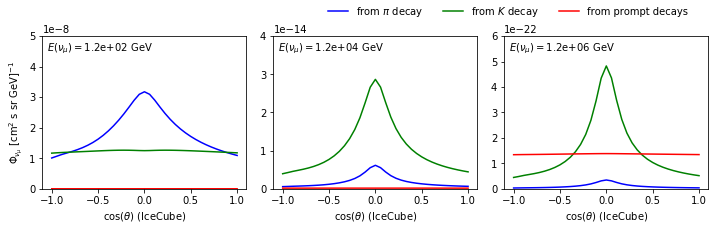

In [7]:
idx0 = 16 # 10 GeV
idx1 = 32 # 10 TeV
idx2 = 48 # 1 PeV

ylim = [5e-8, 4e-14, 6e-22]

fig, axes = plt.subplots(1,3,sharex=True,figsize=(9.8,3.))
for i, idx in enumerate([idx0, idx1, idx2]):
    ax = axes[i]
    ax.text(0.01,0.9,r' $E(\nu_\mu)=${0:2.1e} GeV'.format(e_grid[idx]),
           transform=ax.transAxes)
    for sid, flux in enumerate([flux_summer, flux_winter]):
        if not seasons and sid > 0: continue
        pi_numu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['numu_pi'],flux['numu_total'])]
        k_numu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['numu_k'],flux['numu_total'])]
        pr_numu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['numu_pr'],flux['numu_total'])]
        ax.plot(cos_theta,pi_numu,
                 label=(r'from $\pi$ decay' if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='b')
        ax.plot(cos_theta,k_numu,
                 label=('from $K$ decay' if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='g')
        ax.plot(cos_theta,pr_numu,label=('from prompt decays' 
                 if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='r')

        ax.set_ylim(0,ylim[i])
        ax.set_xlabel(r'$\cos(\theta)$ (IceCube)')
        
axes[0].set_ylabel(r"$\Phi_{\nu_\mu}$ [cm$^{2}$ s sr GeV]$^{-1}$")

plt.figlegend(*axes[0].get_legend_handles_labels(), loc=(0.45,0.9), ncol=3, frameon=False)

plt.tight_layout(rect=[0.0,0.0,1.,.92], pad=0.05)

# Uncomment to save plot
# plt.savefig('zenith_distribution_numu.png', dpi=300)


Plot **muons** from down-going to horizontal zenith (averaged over azimuth)

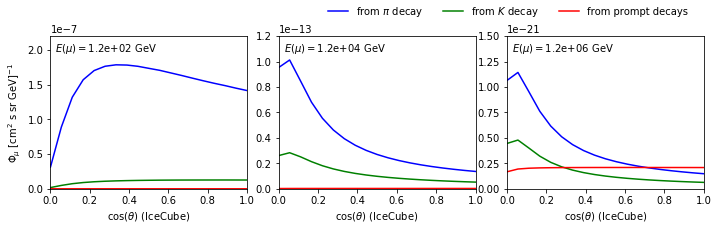

In [8]:
idx0 = 16 # 10 GeV
idx1 = 32 # 10 TeV
idx2 = 48 # 1 PeV

ylim = [2.2e-7, 12e-14, 15e-22]

fig, axes = plt.subplots(1,3,sharex=True,figsize=(9.8,3.))
for i, idx in enumerate([idx0, idx1, idx2]):
    ax = axes[i]
    ax.text(0.01,0.9,r' $E(\mu)=${0:2.1e} GeV'.format(e_grid[idx]),
           transform=ax.transAxes)
    for sid, flux in enumerate([flux_summer, flux_winter]):
        if not seasons and sid > 0: continue
            
        pi_mu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['mu_pi'],flux['mu_total'])]
        k_mu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['mu_k'],flux['mu_total'])]
        pr_mu = [fl[idx]/e_grid[idx]**mag for fl, fln 
                     in zip(flux['mu_pr'],flux['mu_total'])]
        ax.plot(cos_theta,pi_mu,
                 label=(r'from $\pi$ decay' if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='b')
        ax.plot(cos_theta,k_mu,
                 label=('from $K$ decay' if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='g')
        ax.plot(cos_theta,pr_mu,label=('from prompt decays' 
                 if (i==0 and sid==0) else '_nolabel_'),
                 ls='-' if sid==0 else '--',lw=1.5, color='r')

        ax.set_ylim(0,ylim[i])
        ax.set_xlabel(r'$\cos(\theta)$ (IceCube)')
        
axes[0].set_ylabel(r"$\Phi_{\mu}$ [cm$^{2}$ s sr GeV]$^{-1}$")
axes[0].set_xlim(0, 1)
plt.figlegend(*axes[0].get_legend_handles_labels(), loc=(0.45,0.9), ncol=3, frameon=False)

plt.tight_layout(rect=[0.0,0.0,1.,.92], pad=0.05)

# Uncomment to save plot
# plt.savefig('zenith_distribution_muons.png', dpi=300)
